In [1]:
import pickle
import gym
import time
import numpy as np 
import random
import torch
from run_test import *
%matplotlib inline
import matplotlib.pylab as plt


Logging to /tmp/openai-2018-11-28-19-07-56-749495


set up the code for running trajectories with pong


In [2]:
#try it just for two trajectories

env_id = "Hopper-v2"
task_name = ""
env_type = "mujoco"

#env id, env type, num envs, and seed
env = make_vec_env(env_id, env_type, 1, 0,
                   wrapper_kwargs={
                       'clip_rewards':False,
                       'episode_life':False,
                   })


env = VecNormalize(env,ob=True,ret=False,eval=True)
 
agent = PPO2Agent(env, env_type)
#agent = RandomAgent(env.action_space)

/home/dsbrown/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
#get size of state space for neural net input
n = env.observation_space.shape[0]
print(n)

11


In [4]:

def normalize_state(obs):
    obs_highs = env.observation_space.high
    obs_lows = env.observation_space.low
    print(obs_highs)
    print(obs_lows)
    return  2.0 * (obs - obs_lows) / (obs_highs - obs_lows) - 1.0
    #return obs / obs_highs


In [5]:
#Max and min are infinite and -infinite
#can't normalize this way!

In [16]:
checkpoint_min = 20
checkpoint_max = 480
checkpoint_step = 20
checkpoints = []
for i in range(checkpoint_min, checkpoint_max + checkpoint_step, checkpoint_step):
    if i < 100:
        checkpoints.append('000' + str(i))
    elif i < 1000:
        checkpoints.append('00' + str(i))
print(checkpoints)

['00020', '00040', '00060', '00080', '00100', '00120', '00140', '00160', '00180', '00200', '00220', '00240', '00260', '00280', '00300', '00320', '00340', '00360', '00380', '00400', '00420', '00440', '00460', '00480']


In [17]:
demonstrations = []
learning_returns = []
for checkpoint in checkpoints:
    
    model_path = "./models/" + task_name + "/checkpoints/" + checkpoint
    
    agent.load(model_path)
    episode_count = 1
    for i in range(episode_count):
        done = False
        traj = []
        r = 0
        
        ob = env.reset()
        #traj.append(ob)
        #print(ob.shape)
        steps = 0
        acc_reward = 0
        while True:
            action = agent.act(ob, r, done)
            ob, r, done, _ = env.step(action)
            #print(ob.shape)
            traj.append(ob)
            steps += 1
            acc_reward += r[0]
            if done:
                print("checkpoint: {}, steps: {}, return: {}".format(checkpoint, steps,acc_reward))
                break
        print("traj length", len(traj))
        print("demo length", len(demonstrations))
        demonstrations.append(traj)
        learning_returns.append(acc_reward)
    


env.close()


    
    
print(learning_returns)

checkpoint: 00020, steps: 620, return: 645.2108759582043
traj length 620
demo length 0
checkpoint: 00040, steps: 199, return: 168.67658001184464
traj length 199
demo length 1
checkpoint: 00060, steps: 777, return: 801.8340438604355
traj length 777
demo length 2
checkpoint: 00080, steps: 172, return: 199.99827980995178
traj length 172
demo length 3
checkpoint: 00100, steps: 79, return: 106.78841018676758
traj length 79
demo length 4
checkpoint: 00120, steps: 56, return: 89.60489749908447
traj length 56
demo length 5
checkpoint: 00140, steps: 54, return: 91.52551531791687
traj length 54
demo length 6
checkpoint: 00160, steps: 57, return: 100.79859435558319
traj length 57
demo length 7
checkpoint: 00180, steps: 75, return: 142.2026106119156
traj length 75
demo length 8
checkpoint: 00200, steps: 96, return: 191.19741237163544
traj length 96
demo length 9
checkpoint: 00220, steps: 113, return: 218.26495671272278
traj length 113
demo length 10
checkpoint: 00240, steps: 126, return: 233.56191

Let's plot the returns to see if they are roughly monotonically increasing.

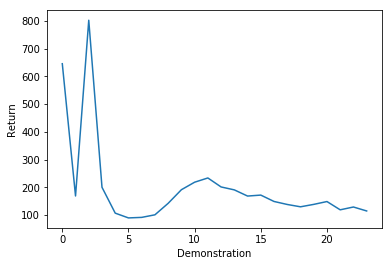

In [19]:
plt.plot(learning_returns)
plt.xlabel("Demonstration")
plt.ylabel("Return")
plt.savefig("hopper.png")
plt.show()

In [ ]:
print(len(learning_returns))
print(len(demonstrations))
print([a[0] for a in zip(learning_returns, demonstrations)])
#cheat and sort them to see if it helps learning
sorted_demos = [x for _, x in sorted(zip(learning_returns,demonstrations), key=lambda pair: pair[0])]

sorted_returns = sorted(learning_returns)
print(learning_returns)
plt.plot(sorted_returns)

Split the data into train and validation sets

In [ ]:
train_demos = []
train_returns = []
valid_demos = []
valid_returns = []

for i,d in enumerate(sorted_demos):
    print(i)
    if i % 5 is not 4:
        train_demos.append(d)
        train_returns.append(sorted_returns[i])
    else:
        valid_demos.append(d)
        valid_returns.append(sorted_returns[i])

print(train_returns)
print(valid_returns)

Now I want to build a neural network to predict the reward the learner is trying to optimize. The inputs are 84x84x4 grayscale images. I'm going to try and use the NIPS architecture from DeepMind.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n):
        super().__init__()
        
        self.fc1 = nn.Linear(n, 64)
        self.fc2 = nn.Linear(64, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = F.leaky_relu(self.fc1(x))
            r = torch.sigmoid(self.fc2(x)) #clip reward?
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    


Now we train the network. I'm just going to do it one by one for now. Could adapt it for minibatches to get better gradients

In [ ]:
def learn_reward(reward_network, optimizer, trajectories, num_iter):
    loss_criterion = nn.CrossEntropyLoss()
    #print(training_data[0])
    cum_loss = 0.0
    for epoch in range(num_iter):
        #pick two random trajectories, traj_i and traj_j and give classification label to later one
        j = np.random.randint(len(trajectories)) 
        i = np.random.randint(len(trajectories))
        while(i == j):
            i = np.random.randint(len(trajectories))
        #print(i,j)
        #traj_i = np.array([[d[0]] for d in trajectories[i]])
        #traj_j = np.array([[d[0]] for d in trajectories[j]])
        traj_i = np.array(trajectories[i])
        traj_j = np.array(trajectories[j])
        #print("orig trajs")
        #print(traj_i)
        #print(traj_j)
        
        if i > j:
            labels = np.array([[0]])
        else:
            labels = np.array([[1]])
            
        traj_i = torch.from_numpy(traj_i).float().to(device)
        traj_j = torch.from_numpy(traj_j).float().to(device)
        labels = torch.from_numpy(labels).to(device)
        #print("trajs")
        #print(traj_i)
        #print(traj_j)
        
        #zero out gradient
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = reward_network.forward(traj_i, traj_j).unsqueeze(0)
        #print(outputs)
        #print(labels)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print stats to see if learning
        item_loss = loss.item()
        cum_loss += item_loss
        if epoch % 50 == 49:
            #with torch.no_grad():
            #    print(torch.cat([reward_network.cum_return(torch.from_numpy(np.array(traj)).float()) for traj in trajectories]))
            print(epoch, cum_loss / 50)
            cum_loss = 0.0
    print("finished training")



        
    

Now we create a reward network and optimize it using the training data.

In [ ]:
#doesn't work on my laptop, CUDA out of memory!!!
reward = Net()
#reward.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward.parameters(), lr = 0.00001, weight_decay=0.001)
learn_reward(reward, optimizer, train_demos, 200)

Print out learned return for all demos. should be roughly increasing

In [ ]:
with torch.no_grad():
    print(torch.cat([reward.cum_return(torch.from_numpy(np.array(traj)).float().to(device)) for traj in demonstrations]))

Look at predicted reward over last demo. It's all +1 since demos are monotonically increasing. Maybe need to truncate demos to fixed length?

In [ ]:

#for last demo

cnt = 0
with torch.no_grad():
    for d in demonstrations:
        rewards = []
        print(cnt)
        for s in d:
            r = reward.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(learning_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()


Trying shorter snippets of the demos, should use a sliding window over all demos to get lots of training data, but just  trying the last H frames for now, where H is length of first (the shortest) demo 

In [ ]:
H = len(train_demos[0])
print(H)
demos_fh = [d[len(d)-H:-1] for d in train_demos]
print(len(demos_fh))
reward_fh = Net()
reward_fh.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward_fh.parameters(),  lr = 0.0001)
learn_reward(reward_fh, optimizer, demos_fh, 2000)

See what predicted returns look like compared to actual

In [ ]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in train_demos]
for i, p in enumerate(pred_returns):
    print(i,p,train_returns[i])

In [ ]:
#print out the actual time series of rewards predicted by nnet for each trajectory.
#They are monotonically increasing, so that's good!
for d in demos_fh:
    print(len(d))

cnt = 0
with torch.no_grad():
    for d in train_demos:
        rewards = []
        print(cnt)
        for s in d:
            r = reward_fh.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(train_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()

Check validation accuracy

In [ ]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in valid_demos]
for i, p in enumerate(pred_returns):
    print(i,p,valid_returns[i])

In [ ]:
torch.save(reward_fh.state_dict(), "./breakout_1_15_lastXreward_sorted.params")

Test reloading policy and see why giving zero reward when I run it inside of PPO..

In [ ]:
test_net = Net()
test_net.to(device)
test_net.load_state_dict(torch.load("./breakout_1_15_lastXreward_sorted.params"))
obs = demonstrations[10][400]
plt.imshow(obs[0,:,:,3])
with torch.no_grad():
    test_r = test_net.cum_return(torch.from_numpy(np.array([obs])).float().to(device)).cpu().numpy().transpose()[0]
print(test_r)

import pickle
filename = 'rand_obs.pkl'
outfile = open(filename,'wb')
pickle.dump(obs,outfile)
outfile.close()

In [ ]:
infile = open(filename,'rb')
new_obs = pickle.load(infile)
infile.close()
(obs == new_obs).all()